In [ ]:
from model.vgg_model import *

In [ ]:
runConfusion("vgg16-model-35-progress-report.hdf5", "Confusion Matrix VGG16 Based Model")

In [ ]:
project_root = os.getcwd()
model_dir = os.path.join(project_root, 'checkpoints')
model_path = os.path.join(model_dir, 'vgg16-model-35-progress-report.hdf5')
runTest(model_path)

In [ ]:
runMain()

# HOG Features

## import required packages
The following code is based on https://github.com/shravankumar147/gtsrb-smai/blob/master/docs/MLP%2BClassfier%2Bon%2BHOG%2BFeatures/MLP%20Classfier%20on%20HOG%20Features.md with modificaitons for Python3 support.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# helper functions 

# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def get_csv(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]


def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box')
    plt.show()
    
# Functions for testimages    
def loadtestimages_from_path(testpath):
    print("[INFO] reading all test images from directory\n")
    gtFile = get_csv(testpath)
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';', quoting=csv.QUOTE_NONE)
    next(reader)
    testfiles = list(reader)
    timg = []
    testimg = []
#     tlbl = []
    for i in testfiles:
    #     print (i[0],i[-1])
        fname = os.path.join(testpath,i[0])
        timg.append(fname)
        tim = plt.imread(fname)
        testimg.append(tim)
#         label = i[-1]
#         tlbl.append(label)
    np.save("Image_n_Labels/testimagenames.npy",timg)
    np.save("Image_n_Labels/testimages.npy",testimg)
#     np.save("Image_n_Labels/testimagelabels.npy",tlbl)
    return timg,testimg
    
def loadtestimages_from_npy():
    print("[INFO] loading from .npy\n")
    timg = np.load("Image_n_Labels/testimagenames.npy", allow_pickle=True)
    testimg = np.load("Image_n_Labels/testimages.npy", allow_pickle=True)
#     tlbl = np.load("Image_n_Labels/testimagelabels.npy")
    return timg,testimg

## Read and Save Training Data

In [3]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy", allow_pickle=True)
    y = np.load("Image_n_Labels/trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../GTSRB/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


/home/ken/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


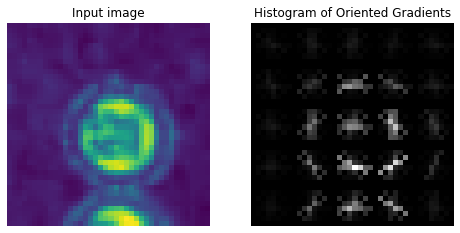

576


In [4]:
# simple test on single image for HoG features
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
# gI2 = cv2.resize(grayim, (40, 40), interpolation = cv2.INTER_CUBIC)
(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
    cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(gI1, hogImage)
print(len(H))

## Read and Save Test Data

In [5]:
testpath="../GTSRB/Final_Test/Images/"
if (os.path.isfile("Image_n_Labels/testimagenames.npy") &  os.path.isfile("Image_n_Labels/testimages.npy")):
    timg,testimg = loadtestimages_from_npy()
else:
    timg,testimg = loadtestimages_from_path(testpath)

[INFO] loading from .npy



## Process and Save HOG For Training

In [6]:
if os.path.isfile("HoGFeatures/HoGfeatures.npy") & os.path.isfile("HoGFeatures/HoGvisualize.npy") :
    print("loading from file ... ")
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy")
    hogviz = np.load("HoGFeatures/HoGvisualize.npy")
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
#         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize.npy", Hviz)
    print("HoGfeatures.npy are saved")  
    print("HoGvisualize.npy are saved")

loading from file ... 
HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat
HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz


## Process and Save HOG For Testing

In [7]:
if os.path.isfile("HoGFeatures/HoGfeatures_test.npy") & os.path.isfile("HoGFeatures/HoGvisualize_test.npy") :
    hogfeat_test = np.load("HoGFeatures/HoGfeatures_test.npy")
    hogviz_test = np.load("HoGFeatures/HoGvisualize_test.npy")
    
    print("HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test")
else:
    print("HoGfeatures_test.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
    #         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures_test.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize_test.npy", Hviz)
    print("HoGfeatures_test.npy are saved")  
    print("HoGvisualize_test.npy are saved")

HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test
HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test


## Convert datatype to float for both training and testing data

In [8]:
# Training
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")

# Testing
X_t = np.array(hogfeat_test).astype("float")


## Create Train, Validation, Test 

In [9]:
features = Xhog
labels = y
Xtest = X_t
(trainData, valData, trainLabels, valLabels) = train_test_split(features, labels,
    test_size=0.1, random_state=84)

## Model Training

In [10]:
from sklearn import linear_model

In [11]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(trainData, trainLabels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
clf.predict(Xtest)

array([ 0.,  0.,  0., ..., 42., 42., 42.])